<a href="https://colab.research.google.com/github/Aelhanchi/torch_vr/blob/master/examples/MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!git clone https://github.com/Aelhanchi/torch_vr.git

In [0]:
import copy
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

import numpy as np
import torch
import torchvision

import os
os.chdir('./torch_vr')
from torch_vr.prev_grads import PrevGrads
from torch_vr.reduce_var import ReduceVar

In [0]:
# uses GPU tensors by default
torch.set_default_tensor_type(torch.cuda.FloatTensor)

In [0]:
# Loads the MNIST dataset
mnist = torchvision.datasets.MNIST(root='./data', train=True, download=False, 
                                   transform=torchvision.transforms.ToTensor)
X = mnist.data.flatten(1).to('cuda')/255.0
y = mnist.targets.to('cuda')
N = X.shape[0]
d_in = 28 * 28
d_out = 9

# optimization parameters
iterations = 5000
batch_size = 256

# defines the model
torch.manual_seed(0)
class Softmax_regression(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = torch.nn.Linear(d_in, d_out, bias=True)
        
        self.A0 = None
        self.Z1 = None
        self.A1 = None

    def forward(self, X):
        self.A0 = X
        self.Z1 = self.lin(self.A0)
        self.Z1.retain_grad()
        self.A1 = torch.nn.functional.log_softmax(self.Z1, dim=1)
        return torch.cat([self.A1, torch.zeros_like(self.A1[:,0:1])], dim=1)
    
# defines the loss and initializes the model
loss_func = torch.nn.NLLLoss(reduction='sum')
model = Softmax_regression()

# caches the starting point
start = copy.deepcopy(model.state_dict())

In [0]:
def minimize(accelerated=False, var_reduce=None):

  # loads the starting point
  model.load_state_dict(start)

  # initializes the optimizer
  if accelerated:
    opt = torch.optim.SGD(model.parameters(), lr=1e-05, weight_decay=0.1, 
                          momentum=0.9, nesterov=True)
  else:
    opt = torch.optim.SGD(model.parameters(), lr=1e-05, weight_decay=0.1)

  # initializes a variance reducer if any requested
  if var_reduce == 'SAGA':
    var_reducer = ReduceVar(model.parameters(), N, [model.lin], method='SAGA')
  elif var_reduce == 'SAG':
    var_reducer = ReduceVar(model.parameters(), N, [model.lin], method='SAG')

  # initializes a list containing the losses
  losses = list()

  for i in tqdm(range(iterations)):
    # resets the gradients to 0
    opt.zero_grad()

    # samples the mini-batch indices uniformly without replacement
    indices = np.random.choice(N, batch_size, replace=False)

    # computes the loss
    loss = loss_func(model(X[indices]), y[indices])
    loss.backward()

    # constructs the gradient estimate
    if var_reduce is None:
      for p in model.parameters():
          p.grad *= N/batch_size
    else:
      var_reducer.reduce_variance([model.Z1.grad], [model.A0], indices)

    # records the true loss at the current iterate  
    with torch.no_grad():
        losses.append(loss_func(model(X), y))

    # takes an optimization step    
    opt.step()
  
  return losses

In [5]:
# runs the non-accelerate algorithms
losses_SGD = minimize(accelerated=False, var_reduce=None)
losses_SAG = minimize(accelerated=False, var_reduce='SAG')
losses_SAGA = minimize(accelerated=False, var_reduce='SAGA')

# runs the accelerated algorithms
losses_acc_SGD = minimize(accelerated=True, var_reduce=None)
losses_acc_SAG = minimize(accelerated=True, var_reduce='SAG')
losses_acc_SAGA = minimize(accelerated=True, var_reduce='SAGA')

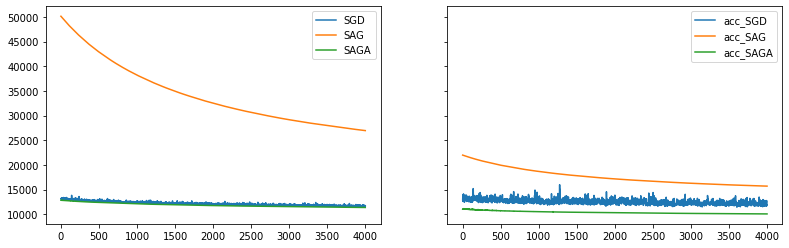

In [6]:
# plots the progress of each of SGD, SAGA, and SAG
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(6.6*2,4))

axes[0].plot(losses_SGD[1000:], label='SGD')
axes[0].plot(losses_SAG[1000:], label='SAG')
axes[0].plot(losses_SAGA[1000:], label='SAGA')
axes[0].legend(loc="upper right");

axes[1].plot(losses_acc_SGD[1000:], label='acc_SGD')
axes[1].plot(losses_acc_SAG[1000:], label='acc_SAG')
axes[1].plot(losses_acc_SAGA[1000:], label='acc_SAGA')
axes[1].legend(loc="upper right");
plt.legend(loc="upper right");

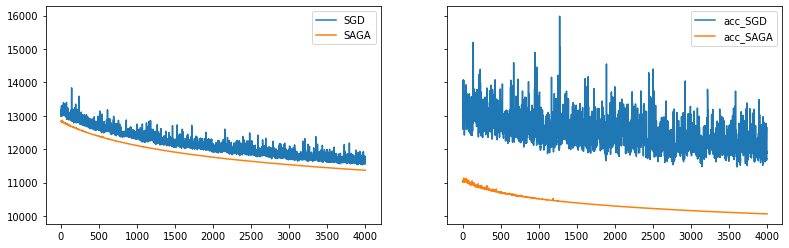

In [7]:
# plots the progress of each of SGD and SAGA
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(6.6*2,4))

axes[0].plot(losses_SGD[1000:], label='SGD')
axes[0].plot(losses_SAGA[1000:], label='SAGA')
axes[0].legend(loc="upper right");

axes[1].plot(losses_acc_SGD[1000:], label='acc_SGD')
axes[1].plot(losses_acc_SAGA[1000:], label='acc_SAGA')
axes[1].legend(loc="upper right");